In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
# Set your data directory
data_dir = 'Rocks'

# Set up ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
image_size = (224, 224)  # Adjust image size as needed
classes = ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']  # Add your class names
num_classes = len(classes)

dataset = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,
    shuffle=True,
    seed=42
)

Found 2069 images belonging to 7 classes.


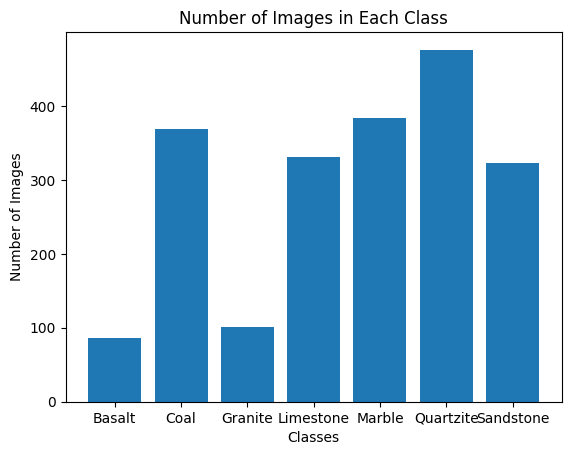

In [2]:
from matplotlib import pyplot as plt

# Get the class indices and counts
class_indices = dataset.class_indices
class_counts = dataset.classes

# Convert class indices to class names
class_names = {v: k for k, v in class_indices.items()}

# Count the occurrences of each class
class_counts_dict = {}
for count in class_counts:
    class_name = class_names[count]
    class_counts_dict[class_name] = class_counts_dict.get(class_name, 0) + 1

# Plot the bar chart
plt.bar(class_counts_dict.keys(), class_counts_dict.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

In [3]:
import numpy as np

# Extract X (images) and y (labels)
X = []
Y = []
for i in range(len(dataset)):
    images, labels = dataset.next()
    X.append(images)
    Y.append(np.argmax(labels, axis=1))  
X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

In [4]:
from sklearn.model_selection import train_test_split

X_train_test, X_val, Y_train_test, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train_test, Y_train_test, test_size=0.2, random_state=40)

In [5]:
base_model = keras.applications.Xception(input_shape=(224,224,3),
                                         include_top=False, 
                                         weights='imagenet')

base_model.trainable = False

model = keras.models.Sequential([
    base_model,
    keras.layers.AveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation='softmax'), 
])

In [6]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 3, 3, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dropout (Dropout)           (None, 128)               0

In [7]:
history = model.fit(X_train, Y_train, 
                    epochs=25,
                    validation_data=(X_val, Y_val),
                    verbose=1,
                )

Epoch 1/25
47/47 [==============================] - 23s 267ms/step - loss: 2.0559 - accuracy: 0.4708 - val_loss: 1.2023 - val_accuracy: 0.5749
Epoch 2/25
47/47 [==============================] - 10s 217ms/step - loss: 0.9875 - accuracy: 0.6676 - val_loss: 1.1500 - val_accuracy: 0.6280
Epoch 3/25
47/47 [==============================] - 10s 217ms/step - loss: 0.8224 - accuracy: 0.7220 - val_loss: 0.9233 - val_accuracy: 0.6570
Epoch 4/25
47/47 [==============================] - 10s 220ms/step - loss: 0.6164 - accuracy: 0.7918 - val_loss: 0.9968 - val_accuracy: 0.6570
Epoch 5/25
47/47 [==============================] - 10s 220ms/step - loss: 0.4817 - accuracy: 0.8381 - val_loss: 0.9226 - val_accuracy: 0.7150
Epoch 6/25
47/47 [==============================] - 10s 219ms/step - loss: 0.3747 - accuracy: 0.8717 - val_loss: 1.0739 - val_accuracy: 0.7005
Epoch 7/25
47/47 [==============================] - 10s 217ms/step - loss: 0.3274 - accuracy: 0.8784 - val_loss: 0.9481 - val_accuracy: 0.7440

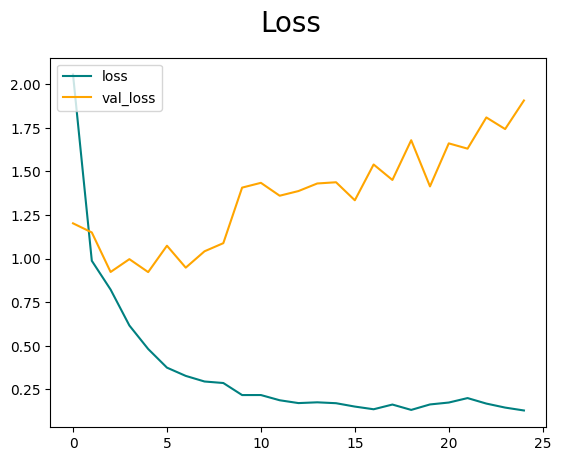

In [8]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

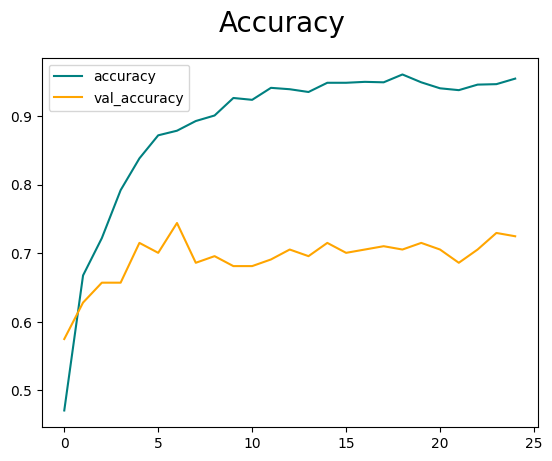

In [9]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [10]:
model.evaluate(X_test,Y_test)

12/12 [==============================] - 3s 273ms/step - loss: 2.9578 - accuracy: 0.6113


[2.957803249359131, 0.6112600564956665]

In [11]:
import pandas as pd
prediction = model.predict(X_test)
Y_pred = np.argmax(prediction, axis=1)

Y_pred_Df = pd.DataFrame(Y_pred)
Y_test_Df = pd.DataFrame(Y_test)


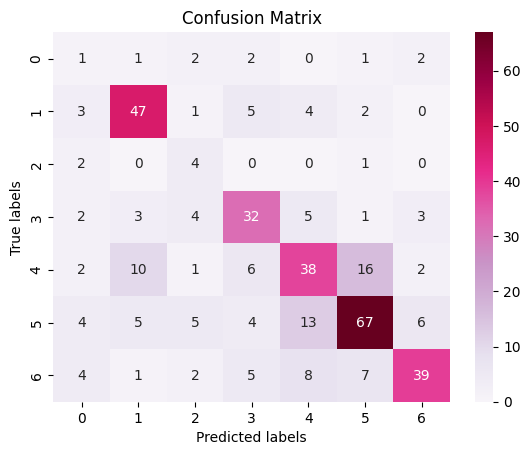

In [12]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix 

# Generate Confusion Metrix
cm = confusion_matrix(Y_pred_Df,Y_test_Df)
ax= plt.subplot()
sns.heatmap(cm, cmap='PuRd', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# Set label,title name
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [13]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_Df,Y_pred_Df, target_names=(classes)))

              precision    recall  f1-score   support

      Basalt       0.11      0.06      0.07        18
        Coal       0.76      0.70      0.73        67
     Granite       0.57      0.21      0.31        19
   Limestone       0.64      0.59      0.62        54
      Marble       0.51      0.56      0.53        68
   Quartzite       0.64      0.71      0.67        95
   Sandstone       0.59      0.75      0.66        52

    accuracy                           0.61       373
   macro avg       0.55      0.51      0.51       373
weighted avg       0.60      0.61      0.60       373

